In [1]:
import tensorflow as tf
import keras
from keras import layers
import os
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt
import numpy as np
import pickle
import soundfile as sf

In [2]:
# this sampling layer is the bottleneck layer of variational autoencoder,
# it uses the output from two dense layers z_mean and z_log_var as input, 
# convert them into normal distribution and pass them to the decoder layer
 
class Sampling(layers.Layer):
    """Uses (mean, log_var) to sample z, the vector encoding a digit."""
 
    def call(self, inputs):
        mean, log_var = inputs
        batch = tf.shape(mean)[0]
        dim = tf.shape(mean)[1]
        epsilon = tf.random.normal(shape=(batch, dim))
        z = mean + tf.exp(0.5 * log_var) * epsilon
        return z
    


class VAE(keras.Model):
    def __init__(self, input_shape, conv_filters, conv_kernels, conv_strides,
                 latent_space_dim, **kwargs):
        super().__init__(**kwargs)
        self.encoder_input_shape = input_shape # [28, 28, 1]
        self.conv_filters = conv_filters # [2, 4, 8]
        self.conv_kernels = conv_kernels # [3, 5, 3]
        self.conv_strides = conv_strides # [1, 2, 2]
        self.latent_space_dim = latent_space_dim # 2
        self.reconstruction_loss_weight = 1000000

        self.encoder = None
        self.decoder = None

        self._num_conv_layers = len(conv_filters)
        self._shape_before_bottleneck = None
        self._model_input = None

        self._build_model()

        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")
 
    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]
 
    def train_step(self, data):
        with tf.GradientTape() as tape:
            mean,log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction),
                    axis=(1, 2),
                )
            )
            kl_loss = -0.5 * (1 + log_var - tf.square(mean) - tf.exp(log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }
    
    def reconstruct(self, images):
        mean, log_var, z = self.encoder.predict(images)
        reconstructed_images = self.decoder.predict(z)
        return reconstructed_images, z
    
    def _build_model(self):
        ## Build encoder
        self._model_input = keras.Input(shape=self.encoder_input_shape) 
        # add conv layers 
        x = self._model_input
        for layer_index in range(self._num_conv_layers):
            x = layers.Conv2D(filters=self.conv_filters[layer_index],
                                kernel_size=self.conv_kernels[layer_index],
                                activation="relu",
                                strides=self.conv_strides[layer_index],
                                padding="same")(x)
            x = layers.BatchNormalization()(x)
        # create bottleneck
        self._shape_before_bottleneck = K.int_shape(x)[1:]
        x = layers.Flatten()(x)
        x = layers.Dense(16, activation="relu")(x)
        mean = layers.Dense(self.latent_space_dim, name="mean")(x)
        log_var = layers.Dense(self.latent_space_dim, name="log_var")(x)
        z = Sampling()([mean, log_var])
        
        self.encoder = keras.Model(self._model_input, [mean, log_var, z], name="encoder")
        self.encoder.summary()

        ## Build decoder
        latent_inputs = keras.Input(shape=(self.latent_space_dim,))
        num_neurons = np.prod(self._shape_before_bottleneck)
        x = layers.Dense(num_neurons, activation="relu")(latent_inputs) #64 * 16 * 64
        x = layers.Reshape(self._shape_before_bottleneck)(x) # use shape before bottleneck
        # add conv transpose layers
        for layer_index in reversed(range(1, self._num_conv_layers)):
            x = layers.Conv2DTranspose(filters=self.conv_filters[layer_index],
                                        kernel_size=self.conv_kernels[layer_index],
                                        activation="relu",
                                        strides=self.conv_strides[layer_index],
                                        padding="same")(x)
            x = layers.BatchNormalization()(x)
        decoder_outputs = layers.Conv2DTranspose(1, 
                                                kernel_size=self.conv_kernels[0],
                                                activation="sigmoid", 
                                                strides=self.conv_strides[0], 
                                                padding="same")(x)
        self.decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
        self.decoder.summary()

    @classmethod
    def load(cls, save_folder="model_vae"):
        parameters_path = os.path.join(save_folder, "parameters.pkl")
        with open(parameters_path, "rb") as f:
            parameters = pickle.load(f)
        print(parameters)
        autoencoder = VAE(*parameters)
        weights_path = os.path.join(save_folder, "weights.h5")
        autoencoder.load_weights(weights_path)
        return autoencoder

    def save_parameters(self, save_folder):
        parameters = [
            self.encoder_input_shape,
            self.conv_filters,
            self.conv_kernels,
            self.conv_strides,
            self.latent_space_dim
        ]
        save_path = os.path.join(save_folder, "parameters.pkl")
        with open(save_path, "wb") as f:
            pickle.dump(parameters, f)


In [3]:
def load_fsdd(spectograms_path):
    x_train = []
    file_paths = []
    for root, _, file_names in os.walk(spectograms_path):
        for file_name in file_names:
            file_path = os.path.join(root, file_name)
            spectogram = np.load(file_path) # ex. (n_bins, n_frames) --> abbiamo bisogno di 3 dimensioni (3 channels)-> (n_bins, n_frames, 1)
            #x_train.append(spectogram)
            file_paths.append(file_path)
    #x_train = np.array(x_train)
    #x_train = x_train[..., np.newaxis] # -> (3000, 256, 64, 1)
    #x_train = tf.data.Dataset.from_tensor_slices(x_train)
    return x_train, file_paths


In [6]:
# Convert the preprocessed spectrograms to a lighter file format
SPECTOGRAMS_PATH = os.path.join("dataset", "fsdd", "spectrograms")
x_train, filepaths = load_fsdd(SPECTOGRAMS_PATH)
#with open(os.path.join('dataset', 'fsdd', 'pickled_spectrograms.npy'), 'wb') as f:
#    np.save(f, x_train)

with open(os.path.join('dataset', 'fsdd', 'pickled_filepaths.npy'), 'wb') as f:
    np.save(f, filepaths)

In [3]:
# Check whether the data contains corrupted samples
with open(os.path.join('dataset', 'fsdd', 'pickled_spectrograms.npy'), 'rb') as f:
    x_train = np.load(f)

with open(os.path.join('dataset', 'fsdd', 'pickled_filepaths.npy'), 'rb') as f:
    filepaths = np.load(f)

nan_count = np.count_nonzero(np.isnan(x_train))
print(nan_count)

0


In [4]:
# Train the model

tf.config.run_functions_eagerly(True)

vae = VAE(
        input_shape=(256, 64, 1),
        conv_filters=(512, 256, 128, 64, 32),
        conv_kernels=(3, 3, 3, 3, 3),
        conv_strides=(2, 2, 2, 2, (2, 1)),
        latent_space_dim=128
    )
vae.compile(optimizer=keras.optimizers.Adam(clipnorm=1.0))
vae.load_weights(os.path.join("model", "trial.weights.h5"))
history = vae.fit(x_train, epochs=1, batch_size=32)

WEIGHTS_Path = os.path.join("model", "trial_1.weights.h5")
vae.save_weights(WEIGHTS_Path)

with open('history.pkl', 'wb') as f:
    pickle.dump(history.history, f)


Z:  Tensor("Min:0", shape=(), dtype=float32) | Tensor("Max:0", shape=(), dtype=float32) __ mean:  Tensor("Min_1:0", shape=(), dtype=float32) | Tensor("Max_1:0", shape=(), dtype=float32) __ log_var:  Tensor("Min_2:0", shape=(), dtype=float32) | Tensor("Max_2:0", shape=(), dtype=float32) __ epsilon:  Tensor("Min_3:0", shape=(), dtype=float32) | Tensor("Max_3:0", shape=(), dtype=float32)


Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 64,   │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 32,   │      5,120 │ input_layer[0][0] │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 128, 32,   │      2,048 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 64, 16,    │  1,179,904 │ batch_normalizat… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 16,    │      1,024 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 32, 8,     │    295,040 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 8,     │        512 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 16, 4, 64) │     73,792 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 4, 64) │        256 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 8, 4, 32)  │     18,464 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 8, 4, 32)  │        128 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 1024)      │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 16)        │     16,400 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mean (Dense)        │ (None, 128)       │      2,176 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ log_var (Dense)     │ (None, 128)       │      2,176 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sampling (Sampling) │ (None, 128)       │          0 │ mean[0][0],       │
│                     │                   │            │ log_var[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,597,040 (6.09 MB)

 Trainable params: 1,595,056 (6.08 MB)

 Non-trainable params: 1,984 (7.75 KB)

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1024)           │       132,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 8, 4, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 16, 4, 32)      │         9,248 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 16, 4, 32)      │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 32, 8, 64)      │        18,496 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 32, 8, 64)      │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 64, 16, 128)    │        73,856 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 64, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_3              │ (None, 128, 32, 256)   │       295,168 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 128, 32, 256)   │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_4              │ (None, 256, 64, 1)     │         2,305 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 533,089 (2.03 MB)

 Trainable params: 532,129 (2.03 MB)

 Non-trainable params: 960 (3.75 KB)

c:\Users\janas\anaconda3\envs\musicmodel\Lib\site-packages\keras\src\saving\saving_lib.py:396: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 94 variables. 
  trackable.load_own_variables(weights_store.get(inner_path))
c:\Users\janas\anaconda3\envs\musicmodel\Lib\site-packages\tensorflow\python\data\ops\structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Z:  tf.Tensor(-4.3987308, shape=(), dtype=float32) | tf.Tensor(3.5266707, shape=(), dtype=float32) __ mean:  tf.Tensor(-4.4433756, shape=(), dtype=float32) | tf.Tensor(3.275835, shape=(), dtype=float32) __ log_var:  tf.Tensor(-7.5396857, shape=(), dtype=float32) | tf.Tensor(0.20425211, shape=(), dtype=float32) __ epsilon:  tf.Tensor(-3.8854191, shape=(), dtype=float32) | tf.Tensor(3.4403744, shape=(), dtype=float32)
   1/9038 ━━━━━━━━━━━━━━━━━━━━ 11:55:57 5s/step - kl_loss: 39.7148 - loss: 3753.2549 - reconstruction_loss: 3713.5400Z:  tf.Tensor(-6.3220344, shape=(), dtype=float32) | tf.Tensor(4.046079, shape=(), dtype=float32) __ mean:  tf.Tensor(-6.3613253, shape=(), dtype=float32) | tf.Tensor(4.3565073, shape=(), dtype=float32) __ log_var:  tf.Tensor(-7.258879, shape=(), dtype=float32) | tf.Tensor(0.18821229, shape=(), dtype=float32) __ epsilon:  tf.Tensor(-3.5287912, shape=(), dtype=float32) | tf.Tensor(3.453711, shape=(), dtype=float32)
   2/9038 ━━━━━━━━━━━━━━━━━━━━ 5:42:14 2s/ste

In [5]:
tf.config.run_functions_eagerly(True)

vae = VAE(
        input_shape=(256, 64, 1),
        conv_filters=(512, 256, 128, 64, 32),
        conv_kernels=(3, 3, 3, 3, 3),
        conv_strides=(2, 2, 2, 2, (2, 1)),
        latent_space_dim=128
    )
vae.compile(optimizer=keras.optimizers.Adam(clipnorm=1.0))
vae.load_weights(os.path.join("model", "trial_4.weights.h5"))
history = vae.fit(x_train, epochs=1, batch_size=32)

WEIGHTS_Path = os.path.join("model", "trial_5.weights.h5")
vae.save_weights(WEIGHTS_Path)

with open('history_5.pkl', 'wb') as f:
    pickle.dump(history.history, f)

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 256, 64,   │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 128, 32,   │      5,120 │ input_layer_2[0]… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 32,   │      2,048 │ conv2d_5[0][0]    │
│ (BatchNormalizatio… │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 64, 16,    │  1,179,904 │ batch_normalizat… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 16,    │      1,024 │ conv2d_6[0][0]    │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 32, 8,     │    295,040 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 8,     │        512 │ conv2d_7[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 16, 4, 64) │     73,792 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 4, 64) │        256 │ conv2d_8[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 8, 4, 32)  │     18,464 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 8, 4, 32)  │        128 │ conv2d_9[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 1024)      │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 16)        │     16,400 │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mean (Dense)        │ (None, 128)       │      2,176 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ log_var (Dense)     │ (None, 128)       │      2,176 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sampling_1          │ (None, 128)       │          0 │ mean[0][0],       │
│ (Sampling)          │                   │            │ log_var[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,597,040 (6.09 MB)

 Trainable params: 1,595,056 (6.08 MB)

 Non-trainable params: 1,984 (7.75 KB)

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1024)           │       132,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_1 (Reshape)             │ (None, 8, 4, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_5              │ (None, 16, 4, 32)      │         9,248 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 16, 4, 32)      │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_6              │ (None, 32, 8, 64)      │        18,496 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 32, 8, 64)      │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_7              │ (None, 64, 16, 128)    │        73,856 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 64, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_8              │ (None, 128, 32, 256)   │       295,168 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 128, 32, 256)   │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_9              │ (None, 256, 64, 1)     │         2,305 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 533,089 (2.03 MB)

 Trainable params: 532,129 (2.03 MB)

 Non-trainable params: 960 (3.75 KB)

9038/9038 ━━━━━━━━━━━━━━━━━━━━ 18937s 2s/step - kl_loss: 30.2621 - loss: 3335.5422 - reconstruction_loss: 3305.2827 - total_loss: 3337.4065


In [5]:
import librosa

from preprocess import MinMaxNormaliser

class SoundGenerator:
    """SoundGenerator is responsible for generating audio spectograms.
    """

    def __init__(self, vae, hop_length):
        self.vae = vae
        self.hop_length = hop_length
        self._min_max_normalizer = MinMaxNormaliser(0, 1)

    def generate(self, spectrograms, min_max_values):
        generated_spectrograms = [] 
        latent_representations = []

        for spectrogram in spectrograms:
            generated_spectogram, latent_representation = self.vae.reconstruct(spectrogram)
            generated_spectrograms.append(generated_spectogram)
            latent_representations.append(latent_representation)

        signals = self.convert_spectograms_to_audio(generated_spectrograms, min_max_values)
        return signals, latent_representations

    def convert_spectograms_to_audio(self, spectograms, min_max_values):
        signals = []
        for spectogram, min_max_value in zip(spectograms, min_max_values):
            # reshape the log spectogram
            log_spectogram = spectogram[:, :, 0] 

            # apply denormalization
            denorm_log_spec = self._min_max_normalizer.denormalise(log_spectogram,
                                                                   min_max_value["min"],
                                                                   min_max_value["max"])

            # log spectogram -> spectogram
            spec = librosa.db_to_amplitude(denorm_log_spec)

            # apply Griffin-Lim
            signal = librosa.istft(spec, hop_length=self.hop_length)

            # append signal to "signals"
            signals.append(signal)

        return signals

In [8]:
# Load the model to generate new music

HOP_LENGTH = 256
SAVE_DIR_ORIGINAL = os.path.join('dataset', 'generation', 'original')
SAVE_DIR_GENERATED = os.path.join('dataset', 'generation', 'generated')
MIN_MAX_VALUES_PATH = os.path.join('dataset', 'fsdd', 'min_max_values.pkl')

vae = VAE(
        input_shape=(256, 64, 1),
        conv_filters=(512, 256, 128, 64, 32),
        conv_kernels=(3, 3, 3, 3, 3),
        conv_strides=(2, 2, 2, 2, (2, 1)),
        latent_space_dim=128
    )

vae.load_weights(os.path.join("model", "trial.weights.h5"))
sound_generator = SoundGenerator(vae, HOP_LENGTH)

# load spectrograms + min max values
with open(MIN_MAX_VALUES_PATH, "rb") as f:
    min_max_values = pickle.load(f)

Z:  Tensor("Min:0", shape=(), dtype=float32) | Tensor("Max:0", shape=(), dtype=float32) __ mean:  Tensor("Min_1:0", shape=(), dtype=float32) | Tensor("Max_1:0", shape=(), dtype=float32) __ log_var:  Tensor("Min_2:0", shape=(), dtype=float32) | Tensor("Max_2:0", shape=(), dtype=float32) __ epsilon:  Tensor("Min_3:0", shape=(), dtype=float32) | Tensor("Max_3:0", shape=(), dtype=float32)


Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 256, 64,   │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 128, 32,   │      5,120 │ input_layer_2[0]… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 32,   │      2,048 │ conv2d_5[0][0]    │
│ (BatchNormalizatio… │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 64, 16,    │  1,179,904 │ batch_normalizat… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 16,    │      1,024 │ conv2d_6[0][0]    │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 32, 8,     │    295,040 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 8,     │        512 │ conv2d_7[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 16, 4, 64) │     73,792 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 4, 64) │        256 │ conv2d_8[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 8, 4, 32)  │     18,464 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 8, 4, 32)  │        128 │ conv2d_9[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 1024)      │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 16)        │     16,400 │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mean (Dense)        │ (None, 128)       │      2,176 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ log_var (Dense)     │ (None, 128)       │      2,176 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sampling_1          │ (None, 128)       │          0 │ mean[0][0],       │
│ (Sampling)          │                   │            │ log_var[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,597,040 (6.09 MB)

 Trainable params: 1,595,056 (6.08 MB)

 Non-trainable params: 1,984 (7.75 KB)

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1024)           │       132,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_1 (Reshape)             │ (None, 8, 4, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_5              │ (None, 16, 4, 32)      │         9,248 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 16, 4, 32)      │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_6              │ (None, 32, 8, 64)      │        18,496 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 32, 8, 64)      │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_7              │ (None, 64, 16, 128)    │        73,856 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 64, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_8              │ (None, 128, 32, 256)   │       295,168 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 128, 32, 256)   │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_9              │ (None, 256, 64, 1)     │         2,305 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 533,089 (2.03 MB)

 Trainable params: 532,129 (2.03 MB)

 Non-trainable params: 960 (3.75 KB)

In [6]:
with open(os.path.join('dataset', 'fsdd', 'pickled_spectrograms.npy'), 'rb') as f:
    spectrograms = np.load(f)

print(spectrograms.shape)

with open(os.path.join('dataset', 'fsdd', 'pickled_filepaths.npy'), 'rb') as f:
    file_paths = np.load(f)

print(file_paths.shape)


(289187, 256, 64, 1)
(289187,)


In [23]:
# select random spectrograms to generate similar music
def select_spectrograms(spectrograms, file_paths, min_max_values, num_new_spectrograms=5):
    sampled_indexes = np.random.choice(range(len(spectrograms)), num_new_spectrograms)
    sampled_spectrograms = spectrograms[sampled_indexes]
    sampled_file_paths = [file_paths[index] for index in sampled_indexes]
    sampled_min_max_values = [min_max_values[file_path] for file_path in
                            sampled_file_paths]
    return sampled_spectrograms, sampled_min_max_values

sampled_spectrograms, sampled_min_max_values = select_spectrograms(spectrograms, file_paths, min_max_values)

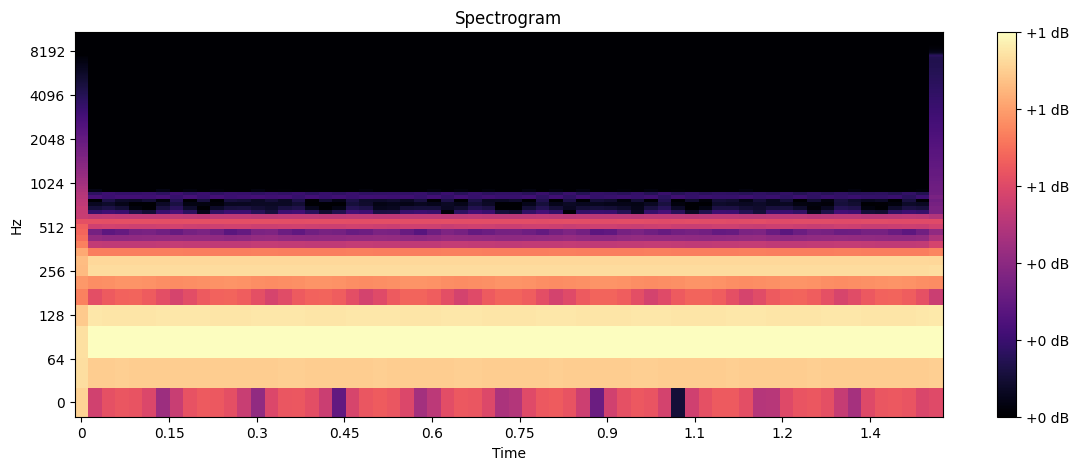

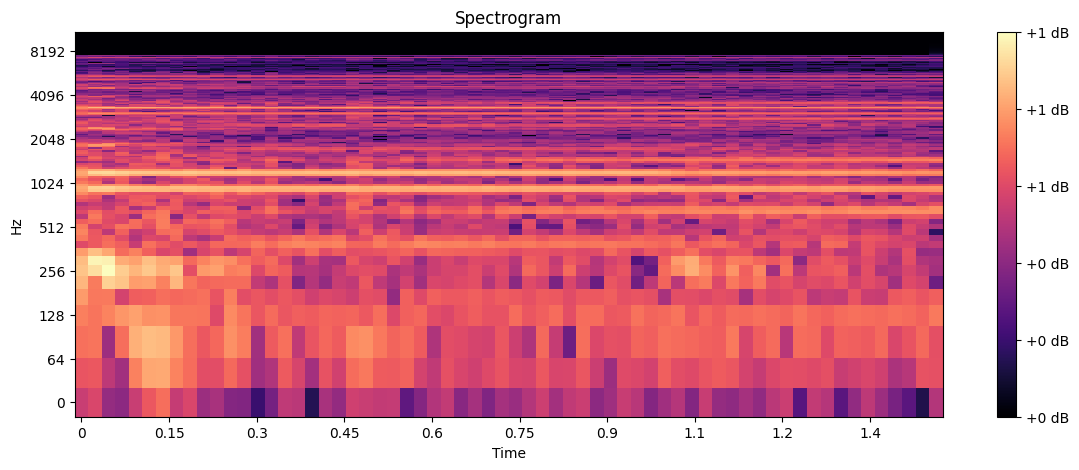

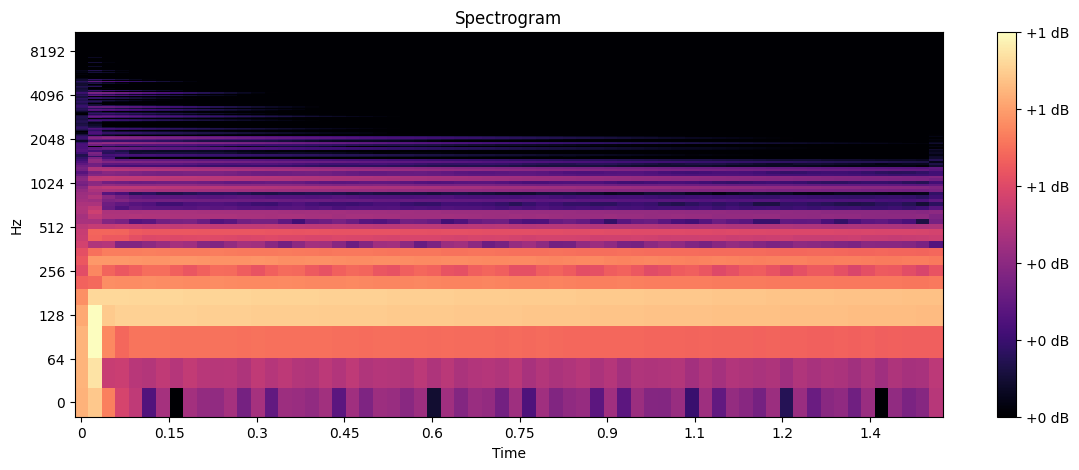

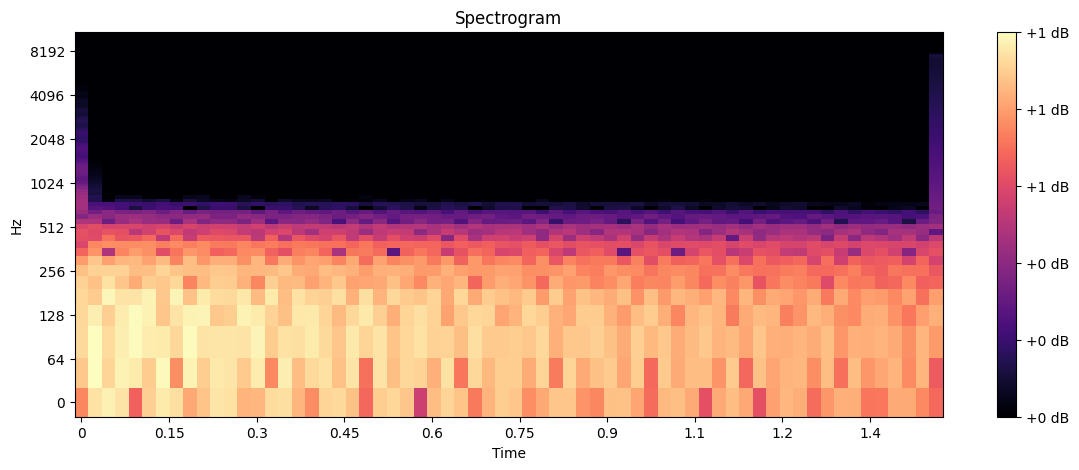

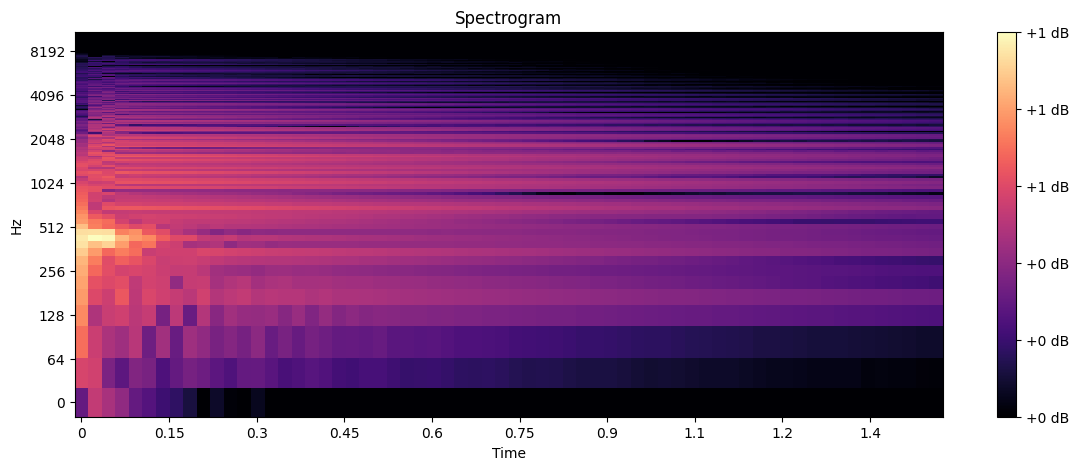

In [10]:
# Plot the original spectrograms

for spec in sampled_spectrograms:
    # Plot the spectrogram
    plt.figure(figsize=(14, 5))
    librosa.display.specshow(np.squeeze(spec), sr=22050, x_axis='time', y_axis='log')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Spectrogram')
    plt.show()

In [11]:
# Generate new spectrograms based on the sampled input spectrograms
mean, log_var, z = vae.encoder.predict(sampled_spectrograms)
generated_spectrograms = vae.decoder.predict(z)

c:\Users\janas\anaconda3\envs\musicmodel\Lib\site-packages\tensorflow\python\data\ops\structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Z:  tf.Tensor(-3.3268604, shape=(), dtype=float32) | tf.Tensor(2.885531, shape=(), dtype=float32) __ mean:  tf.Tensor(-2.6180985, shape=(), dtype=float32) | tf.Tensor(2.6505015, shape=(), dtype=float32) __ log_var:  tf.Tensor(-6.3576612, shape=(), dtype=float32) | tf.Tensor(0.19467327, shape=(), dtype=float32) __ epsilon:  tf.Tensor(-3.3444304, shape=(), dtype=float32) | tf.Tensor(2.9799583, shape=(), dtype=float32)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 427ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


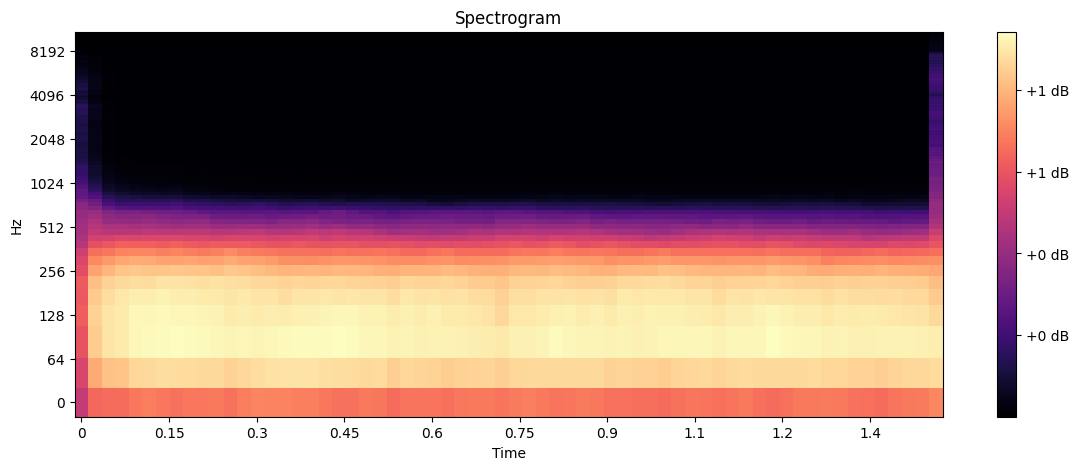

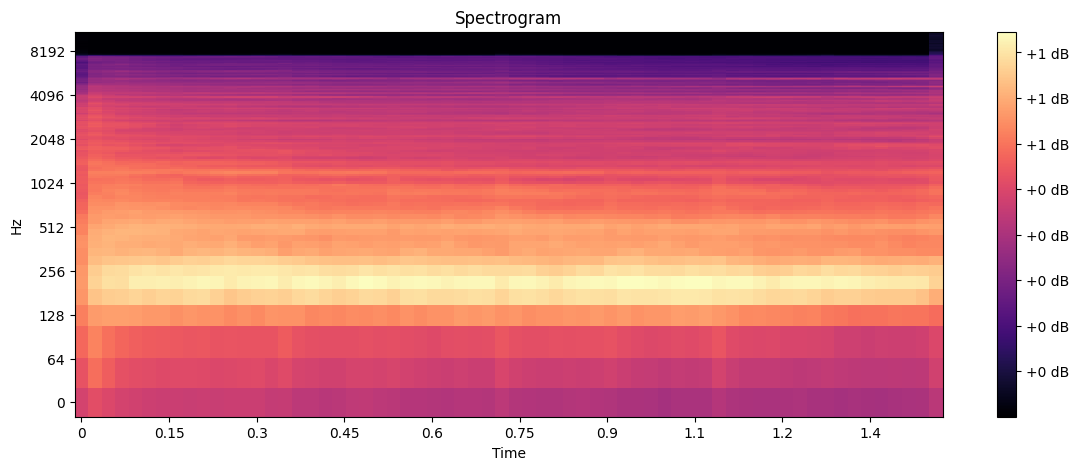

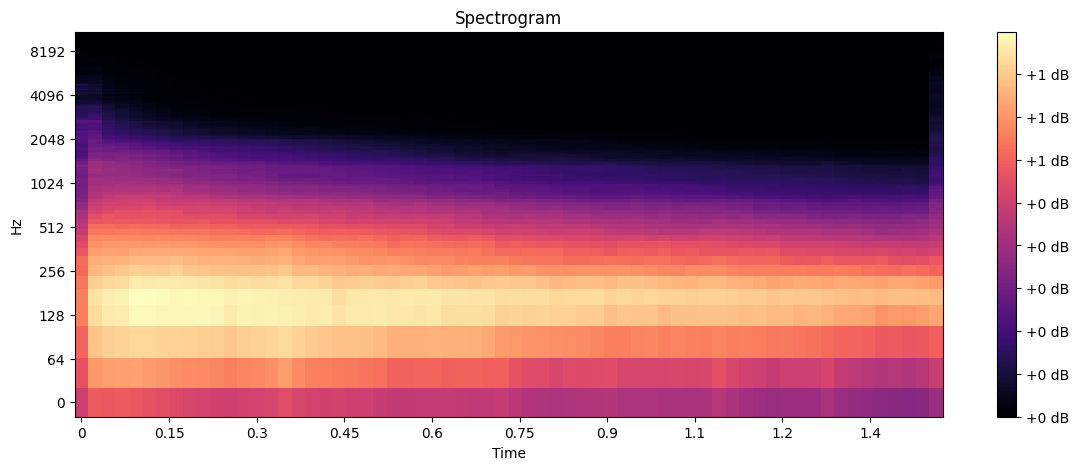

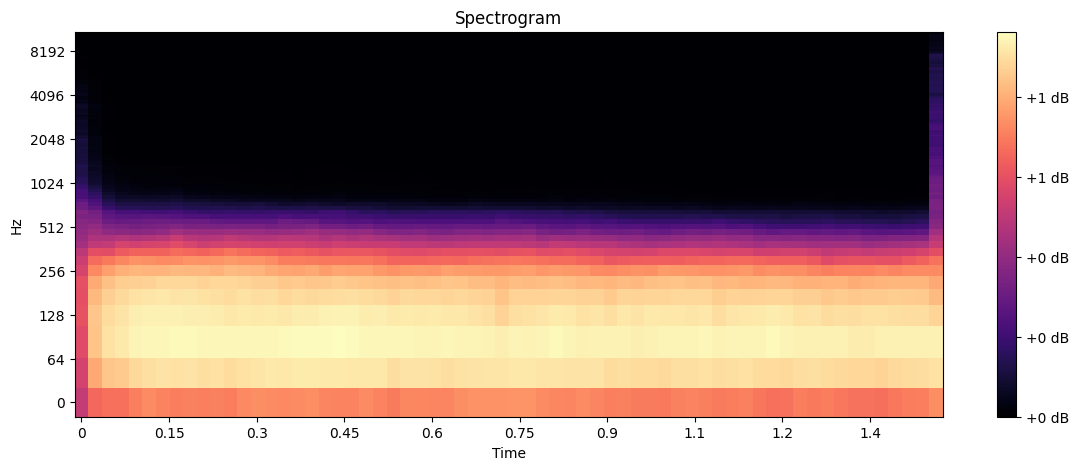

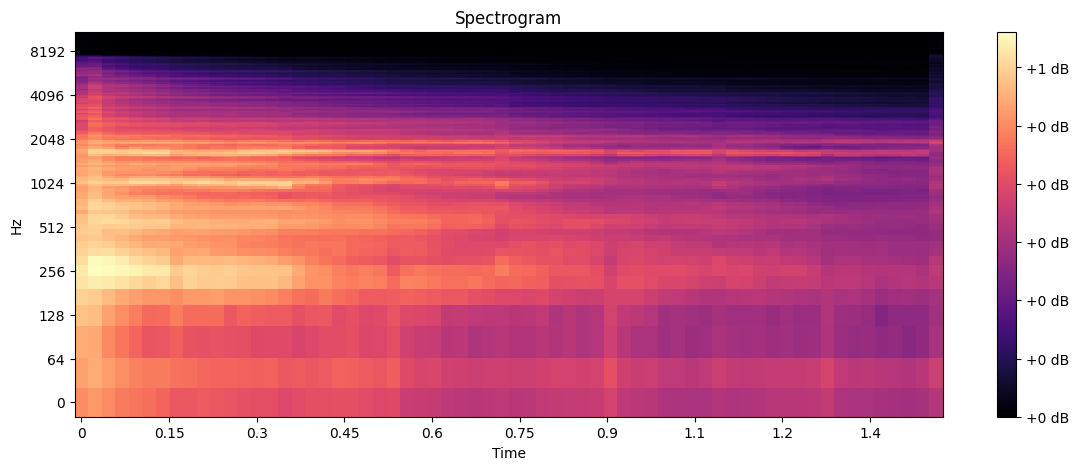

In [12]:
# Plot the newly generated spectrograms

for spec in generated_spectrograms:
    plt.figure(figsize=(14, 5))
    librosa.display.specshow(np.squeeze(spec), sr=22050, x_axis='time', y_axis='log')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Spectrogram')
    plt.show()

In [13]:
# Method to save the converted audio signals
def save_signals(signals, save_dir, sample_rate=22050):
    for i, signal in enumerate(signals):
        save_path = os.path.join(save_dir, str(i) + ".wav")
        sf.write(save_path, signal, sample_rate)

In [25]:
# Convert the newly generated spectrogram samples to audio files

_min_max_normalizer = MinMaxNormaliser(0, 1)

signals = []
for spectrogram, min_max_value in zip(generated_spectrograms, sampled_min_max_values):
    # reshape the log spectrogram
    log_spectogram = spectrogram[:, :, 0] # eliminating the third dimension
    # apply denormalization
    denorm_log_spec = _min_max_normalizer.denormalise(log_spectogram,
                                                            min_max_value["min"],
                                                            min_max_value["max"])

    # log spectrogram -> spectrogram
    spec = librosa.db_to_amplitude(denorm_log_spec)

    # apply Griffin-Lim
    signal = librosa.istft(spec, hop_length=HOP_LENGTH)

    # append signal to "signals"
    signals.append(signal)





# convert spectrogram samples to audio
original_signals = sound_generator.convert_spectograms_to_audio(sampled_spectrograms, sampled_min_max_values)

# save audio signals
save_signals(signals, SAVE_DIR_GENERATED)
save_signals(original_signals, SAVE_DIR_ORIGINAL)

In [ ]:
# Play original audio
from IPython.display import Audio
Audio(original_signals[0], rate=22050)

In [33]:
# Play generated audio
from IPython.display import Audio
Audio(signals[0], rate=22050)

num_new_spec:  31
Z:  tf.Tensor(-6.5902843, shape=(), dtype=float32) | tf.Tensor(4.4262247, shape=(), dtype=float32) __ mean:  tf.Tensor(-6.7584786, shape=(), dtype=float32) | tf.Tensor(4.2807717, shape=(), dtype=float32) __ log_var:  tf.Tensor(-7.271063, shape=(), dtype=float32) | tf.Tensor(0.36668497, shape=(), dtype=float32) __ epsilon:  tf.Tensor(-3.3557248, shape=(), dtype=float32) | tf.Tensor(4.037313, shape=(), dtype=float32)


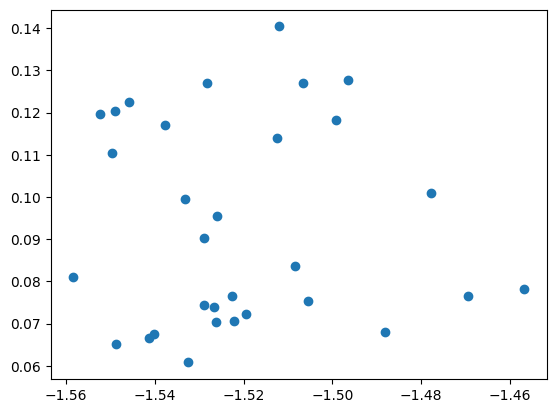

In [22]:
# Plot the latent space

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

sampled_spectrograms, sampled_min_max_values = select_spectrograms(spectrograms, file_paths, min_max_values, num_new_spectrograms=31)

# Encode the data to the latent space
mean,log_var, z = vae.encoder(sampled_spectrograms)
z = np.array(z)

# Use t-SNE to reduce the dimensionality to 2
z_2d = TSNE(n_components=2).fit_transform(z)

# Plot the 2D latent space
plt.scatter(z_2d[:, 0], z_2d[:, 1])
plt.show()
